# Analyse du dataset : Most popular songs on Spotify

## Import des librairies

In [53]:
import plotly.express as px
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import numpy as np
import seaborn as sns

## Import du dataset et statistiques descriptives

In [2]:
spotify=pd.read_csv('spotify-2023.csv', encoding='ISO-8859-1')


In [3]:
spotify.head()

,track_name,artist(s)_name,artist_count,released_year,released_month,released_day,in_spotify_playlists,in_spotify_charts,streams,in_apple_playlists,...,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,Seven (feat. Latto) (Explicit Ver.),"Latto, Jung Kook",2,2023,7,14,553,147,141381703,43,...,125,B,Major,80,89,83,31,0,8,4
1,LALA,Myke Towers,1,2023,3,23,1474,48,133716286,48,...,92,C#,Major,71,61,74,7,0,10,4
2,vampire,Olivia Rodrigo,1,2023,6,30,1397,113,140003974,94,...,138,F,Major,51,32,53,17,0,31,6
3,Cruel Summer,Taylor Swift,1,2019,8,23,7858,100,800840817,116,...,170,A,Major,55,58,72,11,0,11,15
4,WHERE SHE GOES,Bad Bunny,1,2023,5,18,3133,50,303236322,84,...,144,A,Minor,65,23,80,14,63,11,6


In [32]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 953 entries, 0 to 952
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   track_name            953 non-null    object
 1   artist(s)_name        953 non-null    object
 2   artist_count          953 non-null    int64 
 3   released_year         953 non-null    int64 
 4   released_month        953 non-null    int64 
 5   released_day          953 non-null    int64 
 6   in_spotify_playlists  953 non-null    int64 
 7   in_spotify_charts     953 non-null    int64 
 8   streams               953 non-null    object
 9   in_apple_playlists    953 non-null    int64 
 10  in_apple_charts       953 non-null    int64 
 11  in_deezer_playlists   953 non-null    object
 12  in_deezer_charts      953 non-null    int64 
 13  in_shazam_charts      903 non-null    object
 14  bpm                   953 non-null    int64 
 15  key                   858 non-null    ob

On constate que la colonne streams est de type object, on va la convertir en int

In [34]:
spotify['streams'] = pd.to_numeric(spotify['streams'], errors='coerce')  

In [59]:
spotify.describe(exclude=[np.number])

,track_name,artist(s)_name,in_deezer_playlists,in_shazam_charts,key,mode
count,953,953,953,903,858,953
unique,943,645,348,198,11,2
top,Daylight,Taylor Swift,0,0,C#,Major
freq,2,34,24,344,120,550


In [51]:
spotify["artist(s)_name"].value_counts()

artist(s)_name
Taylor Swift                 34
The Weeknd                   22
Bad Bunny                    19
SZA                          19
Harry Styles                 17
                             ..
Karol G, Ovy On The Drums     1
Coolio, L.V.                  1
Kordhell                      1
Kenia OS                      1
Feid, Sech, Jhayco            1
Name: count, Length: 645, dtype: int64

c'est Taylor Swift qui a le plus de chansons dans le top 1000 ! 

In [39]:
top_10_artists = spotify["artist(s)_name"].value_counts().head(10).index

top_10_artists_streams = spotify[spotify["artist(s)_name"].isin(top_10_artists)].groupby("artist(s)_name")["streams"].sum()

top_10_artists_streams.sort_values(ascending=False)


artist(s)_name
The Weeknd        1.418555e+10
Taylor Swift      1.405366e+10
Ed Sheeran        1.390895e+10
Harry Styles      1.160865e+10
Bad Bunny         9.997800e+09
SZA               4.557811e+09
BTS               4.389892e+09
Kendrick Lamar    3.033136e+09
Feid              2.220740e+09
Morgan Wallen     1.666199e+09
Name: streams, dtype: float64

Ceci correspond au nombre de streams total pour les 10 artistes avec le plus de chansons dans le top 1000, on va chercher à le comparer avec les artistes les plus streamés

In [42]:
top_10_streamed_artists = spotify.groupby("artist(s)_name")["streams"].sum().sort_values(ascending=False).head(10)

top_10_streamed_artists


artist(s)_name
The Weeknd         1.418555e+10
Taylor Swift       1.405366e+10
Ed Sheeran         1.390895e+10
Harry Styles       1.160865e+10
Bad Bunny          9.997800e+09
Olivia Rodrigo     7.442149e+09
Eminem             6.183806e+09
Bruno Mars         5.846921e+09
Arctic Monkeys     5.569807e+09
Imagine Dragons    5.272485e+09
Name: streams, dtype: float64

On constate que les artistes les plus streamés ne sont pas forcément ceux qui ont le plus de chansons dans le top 1000, bien que le top 5 contienne les mêmes artistes dans les deux cas.

## Visualisation des données

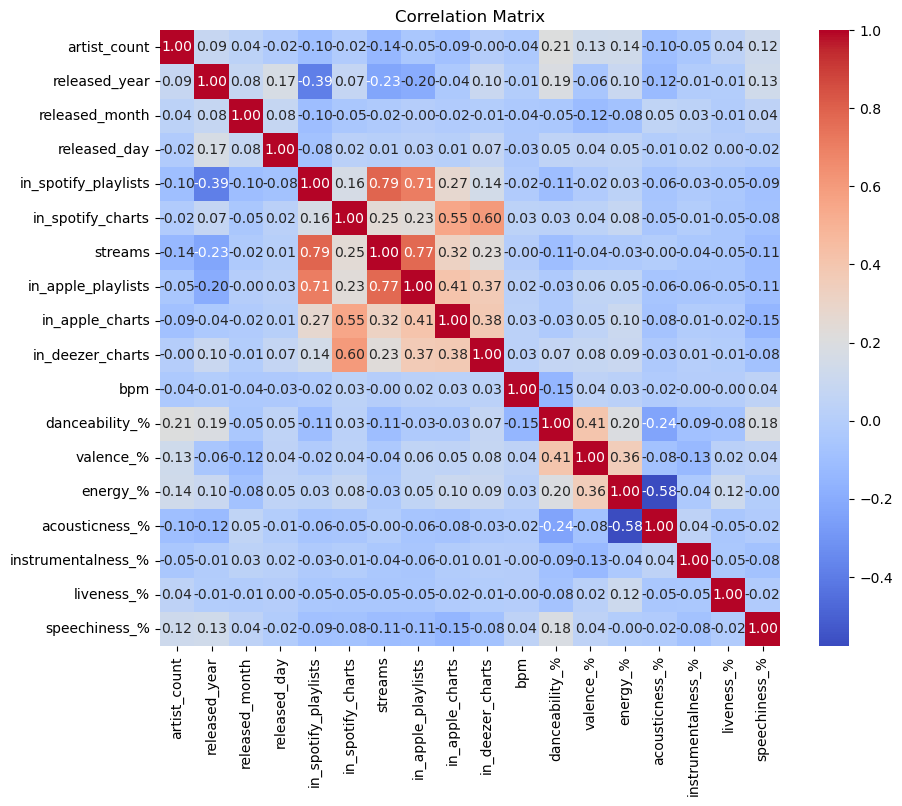

In [72]:
numericspo = spotify.select_dtypes(include=['float64', 'int64'])

correlation_matrix = numericspo.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

On remarque que les variables in spotify playlist et in apple playlist sont fortement corrélées, ce qui peut nous faire supposer que la distribution des streams sur apple music et spotify est similaire.

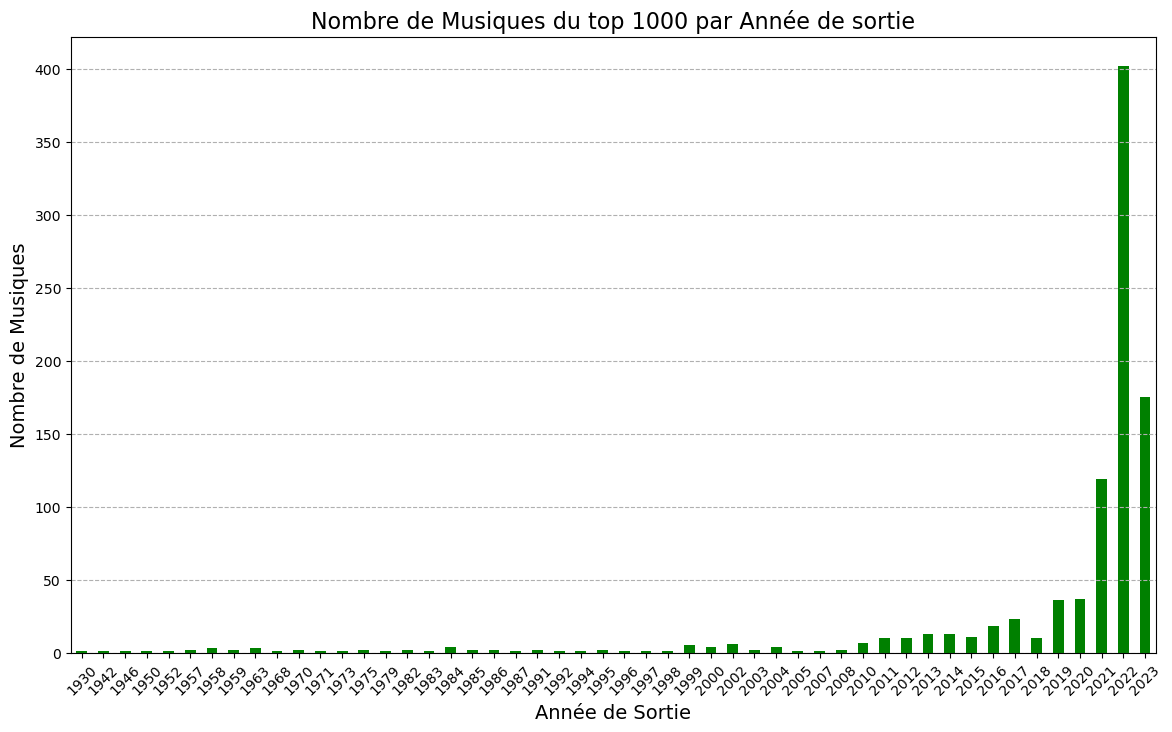

In [73]:
tracks_per_year = spotify['released_year'].value_counts().sort_index()

tracks_per_year
plt.figure(figsize=(14, 8))
tracks_per_year.plot(kind='bar', color='green')
plt.title('Nombre de Musiques du top 1000 par Année de sortie', fontsize=16)
plt.xlabel('Année de Sortie', fontsize=14)
plt.ylabel('Nombre de Musiques', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

La majorité des chansons du top 1000 ont été sorties entre 2021 et 2023, c'est parfaitement logique car les utilisateurs écoutent plus les chansons récentes et à la mode.

## On va maintenant chercher à effectuer une analyse de réseau, afin de comprendre les relations entre les artistes

In [75]:
# Préparation des données pour l'analyse de réseau
# Splitter les noms des artistes pour chaque morceau et créer une liste de tuples représentant les collaborations
collaborations = []

for artists in spotify['artist(s)_name'].dropna().unique():
    artists_list = artists.split(", ")
    if len(artists_list) > 1:  # Seulement considérer les morceaux avec collaborations
        collaborations.extend([(artists_list[i], artists_list[j]) for i in range(len(artists_list)) for j in range(i+1, len(artists_list))])

# Création du réseau de collaborations
G = nx.Graph()
G.add_edges_from(collaborations)

# Calcul de quelques métriques de réseau pour identifier les artistes clés
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)

# Convertir les métriques en DataFrame pour une analyse facile
degree_df = pd.DataFrame(degree_centrality.items(), columns=['Artist', 'Degree Centrality']).sort_values(by='Degree Centrality', ascending=False)
betweenness_df = pd.DataFrame(betweenness_centrality.items(), columns=['Artist', 'Betweenness Centrality']).sort_values(by='Betweenness Centrality', ascending=False)

degree_df.head(), betweenness_df.head()

(          Artist  Degree Centrality
 21  Metro Boomin           0.042339
 7      Bad Bunny           0.038306
 9           Feid           0.038306
 14    The Weeknd           0.032258
 57       Quevedo           0.030242,
             Artist  Betweenness Centrality
 54  Rauw Alejandro                0.058275
 13        Bizarrap                0.040145
 7        Bad Bunny                0.039250
 21    Metro Boomin                0.038987
 9             Feid                0.035546)

In [76]:
import plotly.graph_objects as go
import networkx as nx

# Générer la position des nœuds avec un layout
pos = nx.spring_layout(G)

# Calculer le degré de chaque nœud (nombre de connexions)
degrees = dict(G.degree())
max_degree = max(degrees.values()) if degrees else 1  # Éviter la division par zéro

# Taille des nœuds basée sur leur degré, ajustée pour la visibilité
node_size = [40 * degrees[node] / max_degree + 10 for node in G.nodes()]

# Couleur des nœuds basée sur leur degré
node_color = [degrees[node] for node in G.nodes()]

# Créer des traces pour les arêtes
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.extend([x0, x1, None])
    edge_y.extend([y0, y1, None])

edge_trace = go.Scatter(x=edge_x, y=edge_y, line=dict(width=0.5, color='#888'), mode='lines', hoverinfo='none')

# Créer des traces pour les nœuds
node_x = [pos[node][0] for node in G.nodes()]
node_y = [pos[node][1] for node in G.nodes()]

node_trace = go.Scatter(x=node_x, y=node_y, mode='markers', hoverinfo='text',
                        marker=dict(showscale=True, colorscale='YlOrRd', color=node_color, size=node_size,
                                    colorbar=dict(thickness=15, title='Degré de Connexion')),
                        text=[f'{node}' for node in G.nodes()])

# Créer la figure avec les traces d'arêtes et de nœuds
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(showlegend=False, hovermode='closest',
                                 margin=dict(b=0, l=0, r=0, t=0),
                                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)))

fig.show()


Ce reseau nous apprend beaucoup de chose : On y voit plusieurs groupes d'artistes connectés, certain "clusters" correspondant en fait a des groupes d'artistes géographiquement proches (inde, colombie), et il serait très intéressant d'essayer d'ajouter leur label au jeu de dinnées afin de voir si des artistes d'un même label sont plus connectés entre eux.